In [23]:
#Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt

In [25]:
#Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataloader = DataLoader(datasets.MNIST('.', train=True, download=True, transform=transform), batch_size=64, shuffle=True)

In [27]:
#Define Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

In [29]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

In [31]:
#Initializing models
G, D = Generator().to(device), Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

In [33]:
#Train Loop
epochs = 5
for epoch in range(epochs):
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1).to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        #Train Discriminator
        outputs = D(imgs)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(imgs.size(0), 100).to(device)
        fake_imgs = G(z)
        outputs = D(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        #Train Generator
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [1/5] | D Loss: 0.4562 | G Loss: 2.6473
Epoch [2/5] | D Loss: 1.2484 | G Loss: 0.9216
Epoch [3/5] | D Loss: 0.0981 | G Loss: 4.0576
Epoch [4/5] | D Loss: 0.5107 | G Loss: 2.7372
Epoch [5/5] | D Loss: 0.7981 | G Loss: 1.8522


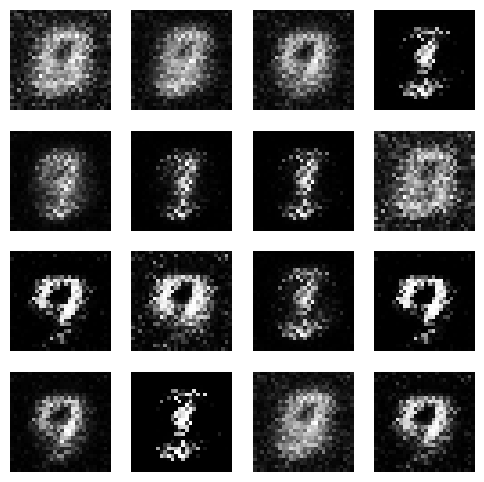

In [34]:
#Visualizing generated digits
z = torch.randn(16, 100).to(device)
generated = G(z).view(-1, 1, 28, 28).cpu().detach()

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated[i][0], cmap='gray')
    plt.axis('off')
plt.show()